## torch函数调用日志文件 按行遍历器

 逐行加载 frida_js生产的日志文件

In [1]:
%%bash

ls -lh  /fridaAnlzAp/frida_js/*RunBuszJs*.log
wc -l /fridaAnlzAp/frida_js/*RunBuszJs*.log

-rwxrwxrwx 1 z z 263M  3月 24 16:57 /fridaAnlzAp/frida_js/frida-trace-out-RunBuszJs-1711270533.log
1045003 /fridaAnlzAp/frida_js/frida-trace-out-RunBuszJs-1711270533.log


In [2]:
TorchFnCallLogFP="/fridaAnlzAp/frida_js/frida-trace-out-RunBuszJs-1711270533.log"

In [3]:

import json
#FirstLineFunc 只在开发时用
def iterLogF(LogFP:str,LineFunc=None,FirstLineFunc=None):
    # LogFP="/fridaAnlzAp/frida_js/frida-trace-out-RunBuszJs-1711270533.log"
    LogF= open(LogFP,"r")
    for k,lnK in enumerate( LogF ):
        if k % 100000 == 0 :  print(f"即将处理第{k}行日志")
        lnK_json=json.loads(lnK)
        if LineFunc is not None:
            LineFunc(k,lnK_json)
        if k ==0 and FirstLineFunc is not None:
            FirstLineFunc(k,lnK_json)
        
    LogF.close()

In [4]:
#显示最后一行的结构
lnEnd_json=None
def assignEveryLn(k,lnK_json):
    global lnEnd_json
    lnEnd_json=lnK_json
        
    
iterLogF("/fridaAnlzAp/frida_js/frida-trace-out-RunBuszJs-1711270533.log",assignEveryLn)

print(type(lnEnd_json), "\n",lnEnd_json)
del lnEnd_json



即将处理第0行日志
即将处理第100000行日志
即将处理第200000行日志
即将处理第300000行日志
即将处理第400000行日志
即将处理第500000行日志
即将处理第600000行日志
即将处理第700000行日志
即将处理第800000行日志
即将处理第900000行日志
即将处理第1000000行日志
<class 'dict'> 
 {'curThreadId': 392463, 'direct': 2, 'fnAdr': '0x7ffff61cdd3c', 'fnCallId': 522488, 'fnSym': {'address': '0x7ffff61cdd3c', 'name': '_M_deallocate_buckets', 'moduleName': 'libc10.so', 'fileName': '/usr/include/c++/9/bits/hashtable.h', 'lineNumber': 374, 'column': 7}}


##  torch函数调用日志文件 装入 sqlite3 

### 初始化sqlite3数据库(表结构)

In [5]:
import sqlite3
# sq3dbConn = sqlite3.connect(':memory:')
sq3dbConn = sqlite3.connect('./FnCallLog.db')

#设置sqlite3.connect.execute.fetchall返回字典列表而非tuple列表
origin_sq3dbConn_row_factory=sq3dbConn.row_factory #先备份
sq3dbConn.row_factory = sqlite3.Row #再修改

#sqlite3 不需要游标cursor,直接用连接执行语句
# sq3Cursr = sq3dbConn.cursor()

print(origin_sq3dbConn_row_factory)


None


In [6]:

# 2+8*2 == 18
sq3dbConn.execute("drop TABLE if exists t_FnSym ")
sq3dbConn.execute("""
CREATE TABLE t_FnSym (
address char(18) PRIMARY KEY,  
name varchar(256), 
moduleName  varchar(32), 
fileName  varchar(256), 
lineNumber integer,
column integer
)
""")

sq3dbConn.execute("drop TABLE if exists t_FnCallLog ")
sq3dbConn.execute("""
CREATE TABLE t_FnCallLog (
id INTEGER PRIMARY KEY, 
curThreadId integer, 
direct short, 
fnAdr char(18),
fnCallId integer,
fnSymId char(18)
)
""")


#有按字段t_FnCallLog.fnCallId查询，因此该字段得有索引
sq3dbConn.execute("""
CREATE INDEX idx__t_FnCallLog__fnCallId ON t_FnCallLog (fnCallId)
""")


### 写 表 FnSym

#### sql语句模板

In [7]:
sqlTmpl_t_FnSym_query=f"select address, name,moduleName,fileName,lineNumber,column from t_FnSym where  address = ?"
sqlTmpl_t_FnSym_insert=f"INSERT INTO t_FnSym (address, name,moduleName,fileName,lineNumber,column) VALUES (?,?,?,?,?,?)"

#### 行回调函数中执行插入

In [8]:

def assertRowEqFnSym(r,fnSym):
    assert  \
r["address"]==fnSym["address"] and \
r["name"]==fnSym["name"] and \
r["moduleName"]==fnSym["moduleName"] and \
r["fileName"]==fnSym["fileName"] and \
r["lineNumber"]==fnSym["lineNumber"] and \
r["column"]==fnSym["column"], f"断言 frida_js项目中 每次 写入的 从DebugSymb中按地址读取出来的 fnSym 是 不变的, rowInSqlite3Tab={r},fnSym={fnSym}"

def sq3_insert_t_FnSym(lnNum,ln):
    fnSym=ln['fnSym'] 
    try:
        row_ls=sq3dbConn.execute(sqlTmpl_t_FnSym_query,[ fnSym['address']  ]).fetchall()
        #若已经有fnSym,则跳过（即不必再插入）
        if row_ls is not None and len(row_ls) > 0:
            #下面断言意义不大 是在验证 sqlite3的主键 是否 真唯一
            assert len(row_ls) == 1, "断言失败，一个地址只能有一个fnSym"  
            #下面断言意义不大 是在验证 frida_js项目中 每次 写入的 从DebugSymb中按地址读取出来的 fnSym 是 不变的
            r=row_ls[0] ; assertRowEqFnSym(r,fnSym)
            return

        #torch源文件路径前的无意义部分换成相对路径
        fileName=fnSym['fileName'].replace('/home/z/torch-repo/pytorch/', './')
        
        sq3dbConn.execute(sqlTmpl_t_FnSym_insert,
[ fnSym['address'], fnSym['name'], fnSym['moduleName'], fnSym['fileName'], fnSym['lineNumber'], fnSym['column'] ])
    except (KeyError, ValueError) as e:
        print("出错行为",ln)
        import traceback
        traceback.print_exception(e)
        raise e






In [9]:
print("从表t_FnSym删除行数 ",sq3dbConn.execute("delete from t_FnSym").rowcount)
    
iterLogF(TorchFnCallLogFP,LineFunc=sq3_insert_t_FnSym)


从表t_FnSym删除行数  0
即将处理第0行日志
即将处理第100000行日志
即将处理第200000行日志
即将处理第300000行日志
即将处理第400000行日志
即将处理第500000行日志
即将处理第600000行日志
即将处理第700000行日志
即将处理第800000行日志
即将处理第900000行日志
即将处理第1000000行日志


#### 开发调试用语句

In [10]:
# iterLogF(TorchFnCallLogFP,FirstLineFunc=sq3_insert_t_FnSym)

In [11]:
sq3dbConn.execute(sqlTmpl_t_FnSym_query,[ '0x7ffff61cdd3c'  ]).fetchall()

###  写 表FnCallLog

#### sql语句模板

In [12]:

sqlTmpl_t_FnCallLog_insert=f"INSERT INTO t_FnCallLog (id, curThreadId,direct,fnAdr,fnCallId,fnSymId) VALUES (?,?,?,?,?,?)"

#### 行回调函数中执行插入

In [13]:

def sq3_insert_t_FnCallLog(lnNum,ln):
    try:
        sq3dbConn.execute(sqlTmpl_t_FnCallLog_insert,[ lnNum,ln['curThreadId'],ln['direct'],ln['fnAdr'],ln['fnCallId'],ln['fnSym']['address'] ])
    except (KeyError, ValueError) as e:
        print("出错行为",ln)
        import traceback
        traceback.print_exception(e)
        raise e
        




In [14]:
print("从表t_FnCallLog删除行数 ",sq3dbConn.execute("delete from t_FnCallLog").rowcount)    
iterLogF(TorchFnCallLogFP,LineFunc=sq3_insert_t_FnCallLog)


从表t_FnCallLog删除行数  0
即将处理第0行日志
即将处理第100000行日志
即将处理第200000行日志
即将处理第300000行日志
即将处理第400000行日志
即将处理第500000行日志
即将处理第600000行日志
即将处理第700000行日志
即将处理第800000行日志
即将处理第900000行日志
即将处理第1000000行日志


#### 开发调试用语句

In [15]:
# iterLogF(TorchFnCallLogFP,FirstLineFunc=sq3_insert_t_FnCallLog)
sq3dbConn.execute("select count(*) from t_FnCallLog").fetchall()

### 提交、关闭sqlite3数据库

In [16]:

sq3dbConn.commit()
# sq3dbConn.close()


In [17]:
!ls -lh

总计 62M
-rwxrwxrwx 1 z z  62M  3月 27 18:48 FnCallLog.db
-rwxrwxrwx 1 z z 109K  3月 27 18:47 neo4j_basic_example.ipynb
-rwxrwxrwx 1 z z  920  3月 27 12:53 readme.md


##  neo4j

### neo4j 社区版 安装

https://hub.docker.com/layers/library/neo4j/4.4.32-community/images/sha256-ce25409b8c3cfaa9a63f4e182753d09266881893e667d0298935ad4bfb0f11e5?context=explore


In [18]:
%%bash
# docker pull neo4j:4.4.32-community
# docker run -d -p 7474:7474 -p 7687:7687 --name neo4j -e "NEO4J_AUTH=neo4j/123456" neo4j:4.4.32-community

http://localhost:7474/browser/  ， 输入用户名、密码，  到达 neo4j 的web控制台


## 写 neo4j 顶点(日志行号）、边（同fnCallId两点） 

写 neo4j 顶点(日志行号）、边（同fnCallId的函数进入指向函数退出） 

，来自 https://neo4j.com/docs/api/python-driver/5.18/#quick-example


### 找进出不平衡的fnCallId

暂时用 以前用spark找出的[sql方式找进出不平衡的fncallid](http://giteaz:3000/frida_analyze_app_src/analyze_by_graph/raw/tag/%E5%AE%8C%E5%A4%87%E4%BE%8B%E5%AD%90/spark3.5.0_pyspark3.5.0_sql%E4%B8%BA%E4%B8%BB/spark_demo_pyspark.ipynb#sql%E6%96%B9%E5%BC%8F%E6%89%BE%E8%BF%9B%E5%87%BA%E4%B8%8D%E5%B9%B3%E8%A1%A1%E7%9A%84fncallid)

In [19]:
# 找进出不平衡的fnCallId
notBalancedFnCallIdLs=[522484]

### python连接neo4j

In [20]:
from neo4j import GraphDatabase, RoutingControl


URI = "neo4j://localhost:7687"
AUTH = ("neo4j", "123456")


In [21]:

driver=GraphDatabase.driver(URI, auth=AUTH)
# driver.close() #到最后再关闭neo4j的连接


### 删除现有顶点、边

#### 删除关系 E_FuncProcess

In [22]:

# 删除关系 E_FuncProcess
Cypher_delete_E_FuncProcess="""
MATCH ()-[r:E_FuncProcess]-()
DELETE r
"""
driver.execute_query(Cypher_delete_E_FuncProcess,database_="neo4j",)


EagerResult(records=[], summary=<neo4j._work.summary.ResultSummary object at 0x71eeb84cd810>, keys=[])

#### 删除顶点 V_FnCallLog

In [23]:

# 删除顶点 V_FnCallLog
Cypher_delete_V_FnCallLog="""
MATCH (n:V_FnCallLog)
DELETE n
"""
driver.execute_query(Cypher_delete_V_FnCallLog,database_="neo4j",)


EagerResult(records=[], summary=<neo4j._work.summary.ResultSummary object at 0x71eeb84b9e70>, keys=[])

### 遍历fnCallId过程中写neo4j顶点、边

#### sqlite3 sql语句模板

In [24]:
sqlTmpl_t_FnCallLog_query_fnCallId_ls="select distinct fnCallId  from t_FnCallLog order by fnCallId asc"

sqlTmpl_t_FnCallLog_query_by_fnCallId="select  *  from t_FnCallLog where fnCallId=?"
#按字段t_FnCallLog.fnCallId查询，因此该字段得有索引

sqlTmpl_t_FnSym_query_by_address="select  *  from t_FnSym where address=?"

In [25]:
#开发调试用
# sqlTmpl_t_FnCallLog_query_fnCallId_ls="select distinct fnCallId  from t_FnCallLog limit 10"


#### 遍历fnCallId过程

In [26]:
from datetime import datetime
def nowDateTimeTxt():
    return datetime.now()   .strftime( '%Y-%m-%d %H:%M:%S %f' ) 


http://giteaz:3000/frida_analyze_app_src/frida_js/src/branch/main/DebugSymbolUtil.ts

```javascript
//方向枚举: 函数进入 或 函数离开
enum Direct{
  // 函数进入
  EnterFn = 1,
  // 函数离开
  LeaveFn = 2,
}

```


In [27]:
#方向枚举: 函数进入 或 函数离开
class Direct:
    #函数进入
    EnterFn = 1
    #函数离开
    LeaveFn = 2

In [28]:
#按照fnCallId查询出 函数进入、函数离开 日志
def queryFnEnterLeave(fnCallId):
    _rowLs=sq3dbConn.execute(sqlTmpl_t_FnCallLog_query_by_fnCallId, [fnCallId]).fetchall()
    # print(_rowLs)
    assert len(_rowLs) == 2
    ls_1=list(filter(lambda r:r["direct"]==Direct.EnterFn, _rowLs)); assert len(ls_1) == 1
    ls_2=list(filter(lambda r:r["direct"]==Direct.LeaveFn, _rowLs)); assert len(ls_1) == 1
    fnEnter=ls_1[0]
    fnLeave=ls_2[0]
    
    fnEnter,fnLeave=_rowLs
    return fnEnter,fnLeave

In [29]:

for fnCallIdRow in sq3dbConn.execute(sqlTmpl_t_FnCallLog_query_fnCallId_ls):
    fnCallId=fnCallIdRow["fnCallId"]
    
    if fnCallId % 10000 == 0 : print(f"{nowDateTimeTxt()},fnCallId={fnCallId}")
    # print("开发调试打印",type(fnCallId), fnCallId.keys())
    
    if fnCallId in notBalancedFnCallIdLs :
        print(f"忽略 不平衡的fnCallId {fnCallId}")
        continue

    #按照fnCallId查询出 函数进入、函数离开 日志
    fnEnter,fnLeave=queryFnEnterLeave(fnCallId)

    fnEnter_fnAdr=fnEnter["fnAdr"]
    fnEnter_curThreadId=fnEnter["curThreadId"]
    fnEnter_direct=fnEnter["direct"]
    #断言 函数进入、函数离开 日志 中的 函数地址 是 相同的
    assert fnEnter_fnAdr == fnLeave["fnAdr"] 
    
    # print(fnEnter["fnAdr"]) #开发调试语句
    # break

    #按照函数地址 查询函数调试信息
    _fnSymLs=sq3dbConn.execute(sqlTmpl_t_FnSym_query_by_address, [fnEnter_fnAdr]).fetchall()
    # 断言 该函数地址 只能查询到一个调试信息
    assert len(_fnSymLs) == 1
    fnSym=_fnSymLs[0]
    # print(fnSym)
    
    fnSym_address=fnSym["address"]
    fnSym_name=fnSym["name"]
    fnSym_moduleName=fnSym["moduleName"]
    fnSym_fileName=fnSym["fileName"]
    fnSym_lineNumber=fnSym["lineNumber"]
    fnSym_column=fnSym["column"]

    #插入到neo4j
    driver.execute_query(
"CREATE (fnEnter_:V_FnCallLog {curThreadId: $curThreadId, direct:$fnEnter_direct, fnAdr:$fnAdr, fnCallId:$fnCallId, fnSym_address:$fnSym_address, fnSym_name:$fnSym_name, fnSym_moduleName:$fnSym_moduleName, fnSym_fileName:$fnSym_fileName, fnSym_lineNumber:$fnSym_lineNumber, fnSym_column:$fnSym_column}) "
"CREATE (fnLeave_:V_FnCallLog {curThreadId: $curThreadId, direct:$fnLeave_direct, fnAdr:$fnAdr, fnCallId:$fnCallId, fnSym_address:$fnSym_address, fnSym_name:$fnSym_name, fnSym_moduleName:$fnSym_moduleName, fnSym_fileName:$fnSym_fileName, fnSym_lineNumber:$fnSym_lineNumber, fnSym_column:$fnSym_column}) "
"CREATE (fnEnter_)-[:E_FuncProcess]->(fnLeave_)",
# "CREATE (fnEnter)-[:Edge2]->(fnLeave)",
# 以下这些是作为 参数 parameters_ 的
curThreadId=fnEnter_curThreadId, 
fnEnter_direct=fnEnter_direct, 
fnLeave_direct=fnEnter_direct, 
fnAdr=fnEnter_fnAdr, 
fnCallId=fnCallId, 
fnSym_address=fnSym_address,
fnSym_name=fnSym_name,
fnSym_moduleName=fnSym_moduleName,
fnSym_fileName=fnSym_fileName,
fnSym_lineNumber=fnSym_lineNumber,
fnSym_column=fnSym_column,

database_="neo4j",
)


IndexError: list index out of range

### 开发调试用语句

In [44]:
#设置sqlite3.connect.execute.fetchall返回tuple列表而非字典列表 （人类可读用）
sq3dbConn.row_factory=origin_sq3dbConn_row_factory

In [65]:
sq3dbConn.execute("select distinct fnCallId from t_FnCallLog limit 10").fetchall()


In [22]:
sq3dbConn.execute(" PRAGMA table_info(t_FnCallLog) ").fetchall()

[(0, 'id', 'INTEGER', 0, None, 1),
 (1, 'curThreadId', 'INTEGER', 0, None, 0),
 (2, 'direct', 'short', 0, None, 0),
 (3, 'fnAdr', 'char(18)', 0, None, 0),
 (4, 'fnCallId', 'INTEGER', 0, None, 0),
 (5, 'fnSymId', 'char(18)', 0, None, 0)]

In [22]:
sq3dbConn.execute(" PRAGMA table_info(t_FnSym) ").fetchall()

[(0, 'address', 'varchar(18)', 0, None, 1),
 (1, 'name', 'varchar(256)', 0, None, 0),
 (2, 'moduleName', 'varchar(32)', 0, None, 0),
 (3, 'fileName', 'varchar(256)', 0, None, 0),
 (4, 'lineNumber', 'INTEGER', 0, None, 0),
 (5, 'column', 'INTEGER', 0, None, 0)]

In [23]:
sq3dbConn.execute("select * from t_FnCallLog where id <=2").fetchall()

[(0, 392463, 1, '0x55555556b4fe', 1, '0x55555556b4fe'),
 (1, 392463, 1, '0x55555556b752', 2, '0x55555556b752'),
 (2, 392463, 1, '0x55555556cc0c', 3, '0x55555556cc0c')]

In [66]:
#还原 
# 设置sqlite3.connect.execute.fetchall返回字典列表而非tuple列表  （程序用）
sq3dbConn.row_factory = sqlite3.Row

In [56]:
sq3dbConn.execute(sqlTmpl_t_FnCallLog_query_by_fnCallId, [1]).fetchall()
# sq3dbConn.execute(sqlTmpl_t_FnSym_query_by_address, ["0x55555556b4fe"]).fetchall()
# driver.execute_query?

[<sqlite3.Row at 0x770ae702e140>, <sqlite3.Row at 0x770ae702fd00>]

**运行到此**

## 可视化neo4j图（以networkx）
networkx在边上 显示neo4j的关系名 ，支持多个关系名，多个关系名写在同一个networkx边上, 获得关系名字列表的简单写法

In [3]:
%%bash

pip install networkx matplotlib

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple


neo4j中的关系名字为 LOVE
neo4j中的关系名字为 LOVE
neo4j中的关系名字为 LOVE
neo4j中的关系名字为 KNOWS
neo4j中的关系名字为 KNOWS
neo4j中的关系名字为 KNOWS


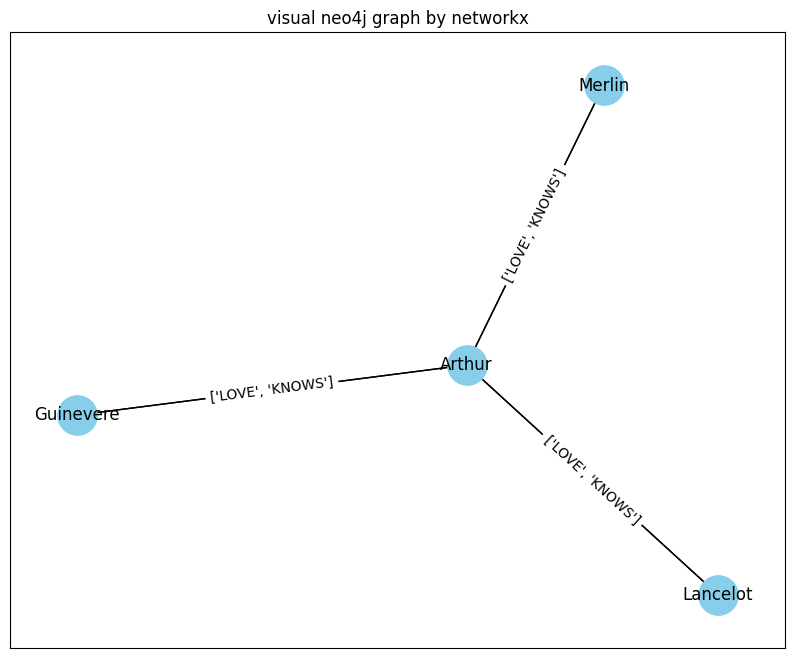

In [39]:
from neo4j import GraphDatabase
import networkx as nx
import matplotlib.pyplot as plt

def visual(driver):
    G = nx.MultiGraph()
    records, _, _ = driver.execute_query(
        "MATCH (n)-[r]->(m)"
        "RETURN n, r, m LIMIT 100",
        database_="neo4j", routing_=RoutingControl.READ,
    )
    for record in records:
        srcV=record['n']['name']
        dstV=record['m']['name']
        relation_type = record['r'].type
        print("neo4j中的关系名字为",relation_type)
        G.add_node(srcV)
        G.add_node(dstV)
        G.add_edge(srcV,dstV,ReltnName=relation_type)
    return G



driver= GraphDatabase.driver(URI, auth=AUTH)
G=visual(driver)
driver.close()

pos = nx.spring_layout(G)  
plt.figure(figsize=(10, 8))

nx.draw_networkx_nodes(G, pos, node_size=800, node_color='skyblue')
nx.draw_networkx_edges(G, pos)
nx.draw_networkx_labels(G, pos)

edge_labels = {(u, v): [d['ReltnName'] for k, d in G[u][v].items()] for u, v in G.edges()}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

plt.title("visual neo4j graph by networkx")
plt.show()

#### 调试写法

In [24]:
#边列表，简陋
G.edges()

MultiEdgeDataView([('Arthur', 'Merlin'), ('Arthur', 'Merlin'), ('Arthur', 'Lancelot'), ('Arthur', 'Lancelot'), ('Arthur', 'Guinevere'), ('Arthur', 'Guinevere')])

In [35]:
#边列表，完备
G.edges(keys=True, data=True)

MultiEdgeDataView([('Arthur', 'Merlin', 0, {'ReltnName': 'LOVE'}), ('Arthur', 'Merlin', 1, {'ReltnName': 'KNOWS'}), ('Arthur', 'Lancelot', 0, {'ReltnName': 'LOVE'}), ('Arthur', 'Lancelot', 1, {'ReltnName': 'KNOWS'}), ('Arthur', 'Guinevere', 0, {'ReltnName': 'LOVE'}), ('Arthur', 'Guinevere', 1, {'ReltnName': 'KNOWS'})])

In [33]:
#获取关系名字ReltnName列表
[  ( f"{u},{v}", G[u][v].items() ) for u, v in G.edges()]

[('Arthur,Merlin',
  ItemsView(AtlasView({0: {'ReltnName': 'LOVE'}, 1: {'ReltnName': 'KNOWS'}}))),
 ('Arthur,Merlin',
  ItemsView(AtlasView({0: {'ReltnName': 'LOVE'}, 1: {'ReltnName': 'KNOWS'}}))),
 ('Arthur,Lancelot',
  ItemsView(AtlasView({0: {'ReltnName': 'LOVE'}, 1: {'ReltnName': 'KNOWS'}}))),
 ('Arthur,Lancelot',
  ItemsView(AtlasView({0: {'ReltnName': 'LOVE'}, 1: {'ReltnName': 'KNOWS'}}))),
 ('Arthur,Guinevere',
  ItemsView(AtlasView({0: {'ReltnName': 'LOVE'}, 1: {'ReltnName': 'KNOWS'}}))),
 ('Arthur,Guinevere',
  ItemsView(AtlasView({0: {'ReltnName': 'LOVE'}, 1: {'ReltnName': 'KNOWS'}})))]

#### 错误写法

In [31]:
#错误写法，只获取到了最后一个关系名字ReltnName
{(u, v): d['ReltnName']  for u, v, k, d in G.edges(keys=True, data=True)}

{('Arthur', 'Merlin'): 'KNOWS',
 ('Arthur', 'Lancelot'): 'KNOWS',
 ('Arthur', 'Guinevere'): 'KNOWS'}